# Task 3.1 Construct Dynamic Circuits

## Objective 1 : FeedForward and Control Flow

### IF statament

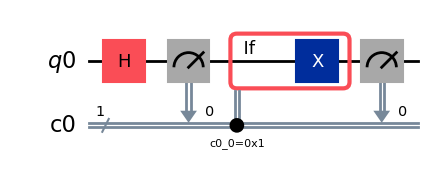

In [1]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister
 
qubits = QuantumRegister(1)
clbits = ClassicalRegister(1)
circuit = QuantumCircuit(qubits, clbits)
(q0,) = qubits
(c0,) = clbits
 
circuit.h(q0)
circuit.measure(q0, c0)
with circuit.if_test((c0, 1)):
    circuit.x(q0)
circuit.measure(q0, c0)
circuit.draw("mpl")
 
# example output counts: {'0': 1024}

### Classical expressions

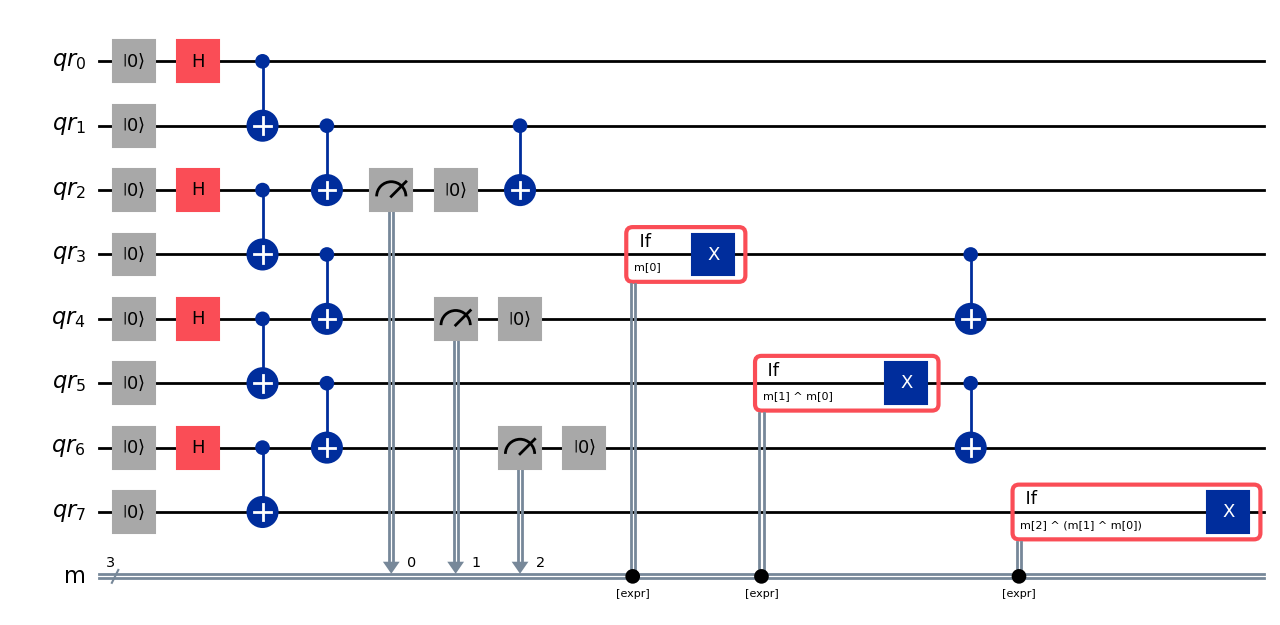

In [2]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.classical import expr
 
num_qubits = 8
if num_qubits % 2 or num_qubits < 4:
    raise ValueError("num_qubits must be an even integer ≥ 4")
meas_qubits = list(range(2, num_qubits, 2))  # qubits to measure and reset
 
qr = QuantumRegister(num_qubits, "qr")
mr = ClassicalRegister(len(meas_qubits), "m")
qc = QuantumCircuit(qr, mr)
 
# Create local Bell pairs
qc.reset(qr)
qc.h(qr[::2])
for ctrl in range(0, num_qubits, 2):
    qc.cx(qr[ctrl], qr[ctrl + 1])
 
# Glue neighboring pairs
for ctrl in range(1, num_qubits - 1, 2):
    qc.cx(qr[ctrl], qr[ctrl + 1])
 
# Measure boundary qubits between pairs,reset to 0
for k, q in enumerate(meas_qubits):
    qc.measure(qr[q], mr[k])
    qc.reset(qr[q])
 
# Parity-conditioned X corrections
# Each non-measured qubit gets flipped iff the parity (XOR) of all
# preceding measurement bits is 1
for tgt in range(num_qubits):
    if tgt in meas_qubits:  # skip measured qubits
        continue
    # all measurement registers whose physical qubit index < tgt
    left_bits = [k for k, q in enumerate(meas_qubits) if q < tgt]
    if not left_bits:  # skip if list empty
        continue
 
    # build XOR-parity expression
    parity = expr.lift(mr[left_bits[0]])  # lift the first bit to Value
    for k in left_bits[1:]:
        parity = expr.bit_xor(
            mr[k], parity
        )  # calculate parity with all other bits
    with qc.if_test(parity):  # Add X if parity is 1
        qc.x(qr[tgt])
 
# Re-entangle measured qubits
for ctrl in range(1, num_qubits - 1, 2):
    qc.cx(qr[ctrl], qr[ctrl + 1])

qc.draw('mpl')

Limitations

* The operand used in an if_test statement must be 32 or fewer bits. 
* Qiskit Runtime cannot broadcast (a bit is broadcasted if it's used in an if_test statement) more than 60 bits at a time. You can explicitly ensure that you are working with different broadcasts by adding barriers.
* Nested conditionals are not allowed. For example, the following code block will not work because it has an if_test inside another if_test:
* Having reset or measurements inside conditionals is not supported.
* Arithmetic operations are not supported.
